# Example 2: pulsed spontaneous parametric down-conversion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from main import *
import numpy as np

##### Set the center frequencies 

In [3]:
# Define the central frequencies of the two down-converted modes and the pump
omega_s_0 = 1265832916458229.0  # signal mode central frequency
omega_i_0 = 1265832916458229.0  # idler mode central frequency
omega_p_0 = omega_s_0 + omega_i_0  # pump mode central frequency

# Calculate the corresponding wavelengths in micrometers
lambda_s_0 = twopi * speed_of_light * 1e6 / omega_s_0
lambda_i_0 = twopi * speed_of_light * 1e6 / omega_i_0
lambda_p_0 = twopi * speed_of_light * 1e6 / omega_p_0

print(f"signal wavelength: {lambda_s_0: .3f} um")
print(f"idler wavelength: {lambda_i_0: .3f} um")
print(f"pump wavelength: {lambda_p_0: .3f} um")

signal wavelength:  1.488 um
idler wavelength:  1.488 um
pump wavelength:  0.744 um


##### Set wave-numbers using the index of refraction calculated from the Sellmeier equation. Here we use parameters given on the United Crystals website: https://www.unitedcrystals.com/KTPProp.html

In [4]:
# create a Sellmeier class along the y- and z-axis
sel_y = Sellmeier(3.0065, 0.03901, 0.04547, 0.01408)
sel_z = Sellmeier(3.3134, 0.05694, 0.05658, 0.01692)


# define the phase-mismatch which takes the sellmeier class as an input
def phase_mismatch(ws, wi):
    k_s = wave_number(sel_z, ws)
    k_i = wave_number(sel_y, wi)
    k_p = wave_number(sel_y, ws + wi)
    return k_s + k_i - k_p


delta_k_0 = phase_mismatch(omega_s_0, omega_i_0)
print(f'phase mismatch: {delta_k_0: .2f}')

phase mismatch:  168634.41


In [5]:
# set frequency range
frequency_width = twopi * 3 * 1e12

dw_s = frequency_width / 1000
dw_i = frequency_width / 1000

ws_range = omega_s_0 + np.arange(- frequency_width / 2, frequency_width / 2 + dw_s, dw_s)
wi_range = omega_i_0 + np.arange(- frequency_width / 2, frequency_width / 2 + dw_i, dw_i)

WS_range, WI_range = np.meshgrid(ws_range, wi_range)

#calculate phase-missmatch. Here we subtract the zeroth order phase-mismatch which would be the result of periodicaly poling the material
delta_k = phase_mismatch(WS_range, WI_range) - delta_k_0

In [6]:
# set crystal length in , 
crystal_length = 2e-2  #crystal length in meters
print(f'crystal length: {crystal_length * 1e2} cm')

# set phase-matching function
phase_matching_function = np.sinc(
    crystal_length * delta_k / 2 / np.pi)  # divide by pi because of numpy sinc definition

crystal length: 2.0 cm


In [7]:
# set effective bandwidth of pump
sigma_p = 5e11
print(f'FWHM of pump intensity: {2 * np.sqrt(np.log(2)) * sigma_p * 1e-9 / twopi: .2f} GHz')


def pump(ws, wi):
    return (1 / (sigma_p ** 2 * np.pi)) ** 0.25 * np.exp(-(ws + wi - omega_p_0) ** 2 / 2 / sigma_p ** 2)


# evaluate pump amplitude
alpha = pump(WS_range, WI_range)

FWHM of pump intensity:  132.51 GHz


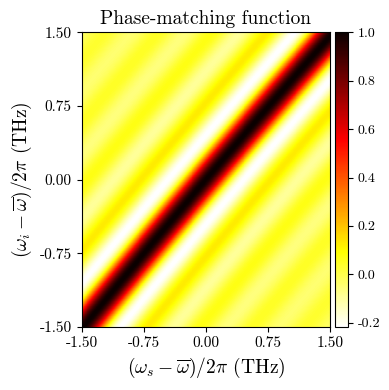

In [8]:
# check range of frequencies by plotting phase-matching function

ticks_s = np.linspace(np.round(np.min((ws_range - omega_s_0) * 1e-12 / twopi), 2),
                      np.round(np.max((ws_range - omega_s_0) * 1e-12 / twopi), 2),
                      5)

ticks_i = np.linspace(np.round(np.min((wi_range - omega_i_0) * 1e-12 / twopi), 2),
                      np.round(np.max((wi_range - omega_i_0) * 1e-12 / twopi), 2),
                      5)

fig, ax = plt.subplots(figsize=(4, 4))
im0 = ax.pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                    (WI_range - omega_i_0) * 1e-12 / twopi,
                    phase_matching_function,
                    #shading='gouraud',
                    #shading='flat',
                    vmin=phase_matching_function.min(),
                    vmax=phase_matching_function.max(),
                    cmap='hot_r')
ax.set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax.set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax.set_title(r"Phase-matching function", fontsize=fs)
ax.tick_params(axis='both', labelsize=ts)
ax.set_yticks(ticks_s)
ax.set_xticks(ticks_i)
plt.colorbar(im0, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.tight_layout()
plt.show()

In [9]:
# set normalized joint spectral amplitude

jsa = alpha * phase_matching_function / np.sqrt(
    np.sum(np.abs(alpha * phase_matching_function) ** 2) * dw_s * dw_i)


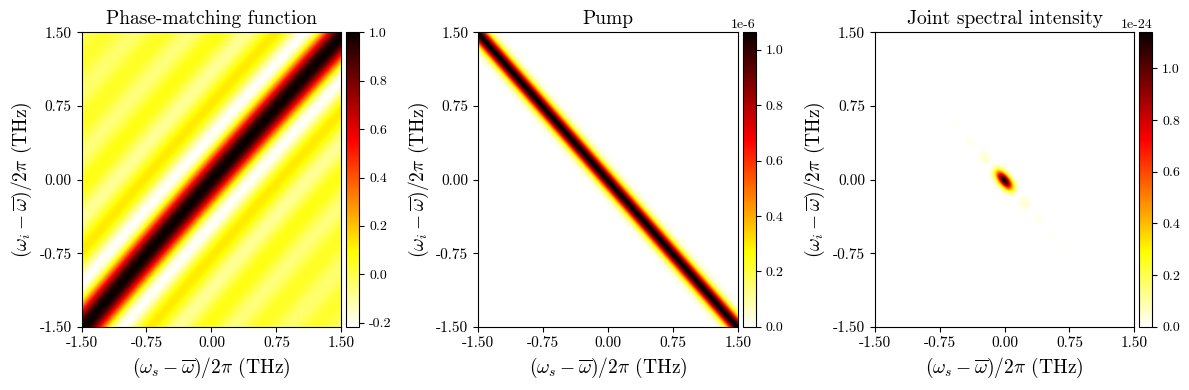

In [10]:
# plot the phase-matching fucntion, pump amplitude, and joint spectral amplitude

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

im0 = ax[0].pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                       (WI_range - omega_i_0) * 1e-12 / twopi,
                       phase_matching_function,
                       shading='gouraud',
                       vmin=phase_matching_function.min(),
                       vmax=phase_matching_function.max(),
                       cmap='hot_r')
ax[0].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_title(r"Phase-matching function", fontsize=fs)
ax[0].tick_params(axis='both', labelsize=ts)
ax[0].set_yticks(ticks_s)
ax[0].set_xticks(ticks_i)

im1 = ax[1].pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                       (WI_range - omega_i_0) * 1e-12 / twopi,
                       alpha,
                       shading='gouraud',
                       vmin=alpha.min(),
                       vmax=alpha.max(),
                       cmap='hot_r')
ax[1].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[1].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[1].set_title(r"Pump", fontsize=fs)
ax[1].tick_params(axis='both', labelsize=ts)
ax[1].set_yticks(ticks_s)
ax[1].set_xticks(ticks_i)

im2 = ax[2].pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                       (WI_range - omega_i_0) * 1e-12 / twopi,
                       np.abs(jsa) ** 2,
                       shading='gouraud',
                       vmin=(np.abs(jsa).min()) ** 2,
                       vmax=(np.abs(jsa).max()) ** 2,
                       cmap='hot_r')
ax[2].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[2].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[2].set_title(r"Joint spectral intensity", fontsize=fs)
ax[2].tick_params(axis='both', labelsize=ts)
ax[2].set_yticks(ticks_s)
ax[2].set_xticks(ticks_i)

plt.colorbar(im0, cax=make_axes_locatable(ax[0]).append_axes("right", size="5%", pad=0.05))
plt.colorbar(im1, cax=make_axes_locatable(ax[1]).append_axes("right", size="5%", pad=0.05))
plt.colorbar(im2, cax=make_axes_locatable(ax[2]).append_axes("right", size="5%", pad=0.05))
plt.tight_layout()
plt.show(fig)

In [11]:
# define the coincidence probability
@np.vectorize
def coincidence(delay):
    phase = np.exp(-1j * (WS_range - WI_range) * delay)
    return 1 / 2 - 1 / 2 * np.sum(np.conj(jsa) * jsa.T * phase) * dw_s * dw_i

In [12]:
# evaluate 
delay_range = np.linspace(-5e-12, 5e-12, 200)
p_SPDC = np.real_if_close(coincidence(delay_range))

In [13]:
ticks_d = np.round(np.linspace(np.min(delay_range * 1e12), np.max(delay_range * 1e12), 5), 2)

print(ticks_d)

[-5.  -2.5  0.   2.5  5. ]


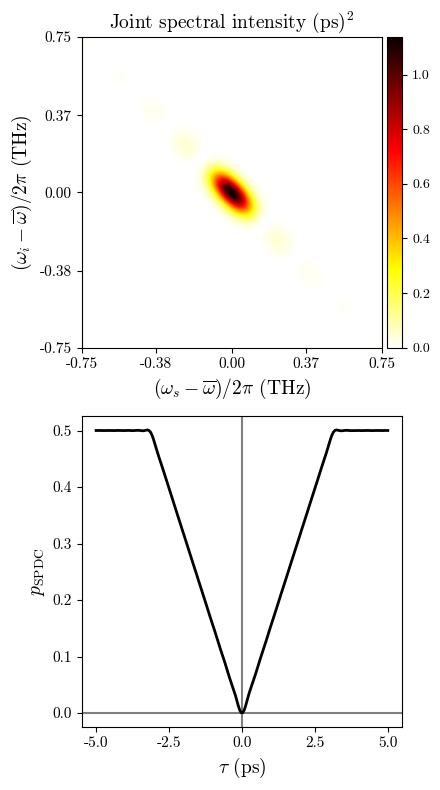

In [15]:
# plot joint spectral amplitude and coincidence probability

ticks_s = np.round(np.linspace(np.min((ws_range - omega_s_0)[250:750] * 1e-12 / twopi),
                               np.max((ws_range - omega_s_0)[250:750] * 1e-12 / twopi), 5), 2)

ticks_i = np.round(np.linspace(np.min((wi_range - omega_i_0)[250:750] * 1e-12 / twopi),
                               np.max((wi_range - omega_i_0)[250:750] * 1e-12 / twopi), 5), 2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.5, 8))

im0 = ax[0].pcolormesh((WS_range - omega_s_0)[250:750, 250:750] * 1e-12 / twopi,
                       (WI_range - omega_i_0)[250:750, 250:750] * 1e-12 / twopi,
                       np.abs(jsa[250:750, 250:750]) ** 2 * 1e12 ** 2,
                       shading='gouraud',
                       vmin=0,
                       vmax=np.max(np.abs(jsa[250:750, 250:750]) ** 2 * 1e12 ** 2),
                       cmap='hot_r',
                       )
ax[0].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_title(r"Joint spectral intensity $(\mathrm{ps})^2$", fontsize=fs)
ax[0].tick_params(axis='both', labelsize=ts)
ax[0].set_yticks(ticks_s)
ax[0].set_xticks(ticks_i)

ax[1].plot(delay_range * 1e12, p_SPDC,
           linewidth=2,
           color='black')
ax[1].set_xlabel(r"$\tau$ (ps)", fontsize=fs)
ax[1].set_ylabel(r"$p_\mathrm{SPDC}$", fontsize=fs)
ax[1].tick_params(axis='both', labelsize=ts)
ax[1].axhline(0, color='black', alpha=0.5)
ax[1].axvline(0, color='black', alpha=0.5)
ax[1].set_xticks(ticks_d)

plt.colorbar(im0, cax=make_axes_locatable(ax[0]).append_axes("right", size="5%", pad=0.05))
plt.tight_layout()
fig.savefig('figures/fig4.png', dpi=300, bbox_inches='tight')
plt.show(fig)